In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from utilities.data_processing import ProcessInput
%matplotlib inline

# Modelling LFC results

Attempt to build a model to predict the result of a liverpool game

### Load fixture history data

Currently only interested in the Premier League, so limit the data to that for now

In [2]:
file_path = os.path.join('data', 'liverpool_fixture_history.csv')
df = pd.read_csv(file_path)
df = df[df['competition'] == 'Premier League']
df.head(5)

,away_score,competition,date,home_score,nth_game_this_season,opposition,venue
64,0,Premier League,14/08/1993,2,1,Sheffield Wednesday,Anfield
65,1,Premier League,18/08/1993,3,2,Queens Park Rangers,Loftus Road
66,0,Premier League,22/08/1993,5,3,Swindon Town,County Ground
67,2,Premier League,25/08/1993,1,4,Tottenham Hotspur,Anfield
68,0,Premier League,28/08/1993,2,5,Leeds United,Anfield


## Feature extraction

Use predefined transformation method to add in additional features including:

- A scaled version of the date to act as a weight column, giving more weight to more recent games
- Extracting the day of week from the data column, as well as days since last game
- Drop the venue column after converting it to a home/away flag
- Add the current win streak and undefeated streaks as integers
- Create a beatability index for each oppositon based on previous performance against them

In [3]:
processor = ProcessInput()
df = processor.fit_transform(df)
df.head()

,away_score,competition,date,home_score,nth_game_this_season,opposition,liverpool_at_home,result,win_flag,loss_flag,beatability_index,day_of_week,days_since_last_game,win_streak,undefeated_streak,pl_gameweek,PPG,season_number,season_points,n_times_teams_played
0,0,Premier League,1.000000,5,29,39,True,1,True,False,0.500000,1,4,0,10,20,1.900000,24,38,13
1,3,Premier League,0.999551,3,28,0,False,0,False,False,0.181818,4,5,1,9,19,1.842105,24,35,48
2,0,Premier League,0.998989,4,27,7,False,1,True,False,0.400000,6,4,0,8,18,1.888889,24,34,5
3,0,Premier League,0.998539,0,26,43,True,0,False,False,0.300000,2,3,0,7,17,1.823529,24,31,23
4,1,Premier League,0.998202,1,25,17,True,0,False,False,0.400000,6,8,2,6,16,1.875000,24,30,47


### Average performance vs specific opposition

A beatability index gives an indication of how well Liverpool plays against each team in the premier league.

For any given opposition, it is simply:

\begin{align}
b_{opp} = \frac{games\ won_{opp}}{total\ games_{opp}} - \frac{games\ lost_{opp}}{total\ games_{opp}}
\end{align}



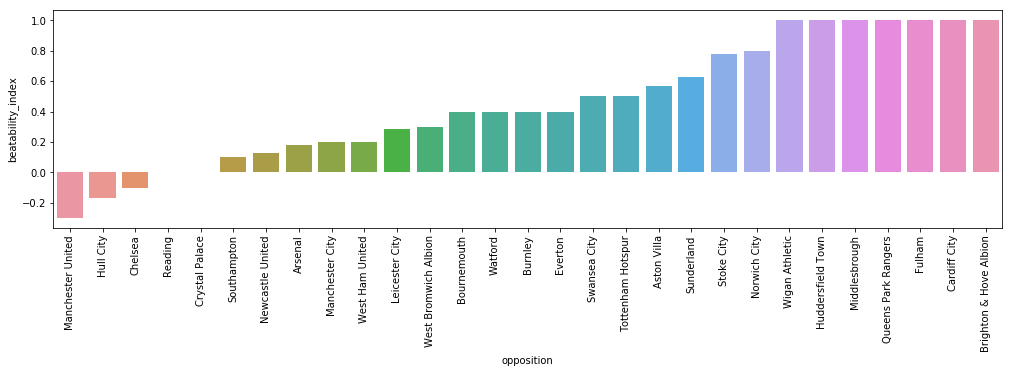

In [4]:
plt.figure(figsize=[17, 4])
barplot = sns.barplot(x='opposition', y='beatability_index', data=processor.beatability_df.sort_values(by='beatability_index'))
for label in barplot.get_xticklabels():
    label.set_rotation(90)

### Performance as season progresses

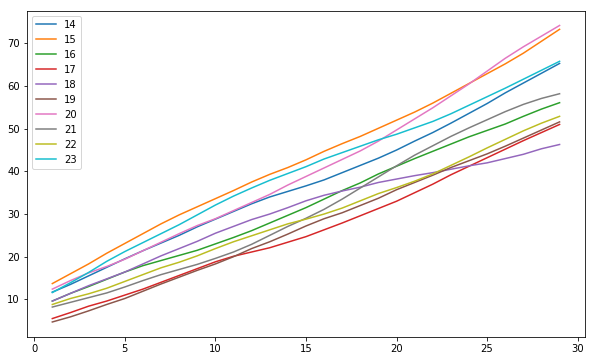

In [5]:
seasons_to_plot = 10

fig = plt.figure(figsize=[10,6])

for season in range(df['season_number'].max() - seasons_to_plot, df['season_number'].max()):
    season_df = df[df['season_number'] == season]   
    plt.plot(season_df['pl_gameweek'], season_df['season_points'].rolling(10).mean(), label=season)
    
plt.legend()

### Drop data that we can't use in training

In [6]:
# Only interested in the Premier League for now
df = df[df['competition'] == 'Premier League']
df.drop('competition', axis=1, inplace=True)

In [7]:
# Scores can't be used in prediction
df.drop(['away_score', 'home_score'], axis=1, inplace=True)

In [8]:
# Drop any other features we don't want to use in training
df.drop(['season_number', 'season_points'], axis=1, inplace=True)

### Correlation of features with label

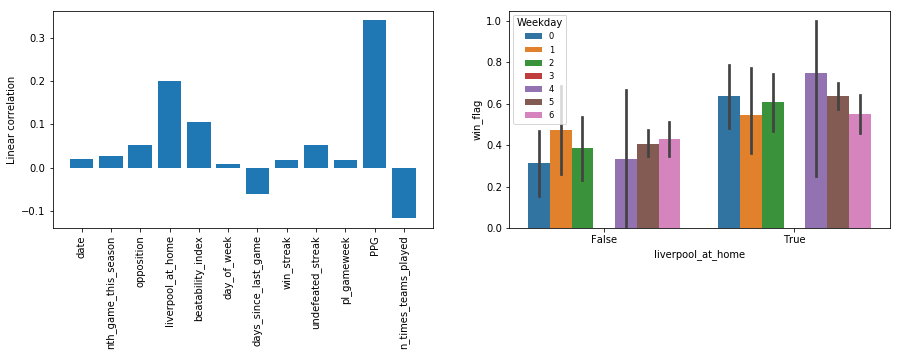

In [9]:
# Calculate correlation matrix then extract the correlations with respect to the win flag
corr_mat = df.corr()
correlation_with_win = corr_mat['win_flag']
correlation_with_win = correlation_with_win[~np.isin(correlation_with_win.index.values, 
                                                     ['win_flag', 'result', 'loss_flag'])]

# Plot these correlations
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,4])
ax[0].bar(np.arange(len(correlation_with_win)), correlation_with_win)
ax[0].set_xticks(np.arange(len(correlation_with_win)))
ax[0].set_xticklabels(correlation_with_win.index.values, rotation=90)
ax[0].set_ylabel('Linear correlation')

# Plot a bar chart to see how home advantage and day of week affect the win rate
sns.barplot(data=df, x='liverpool_at_home', y='win_flag', hue='day_of_week', ax=ax[1])
ax[1].legend(loc=2, title='Weekday', fontsize='small')
plt.show()

So home advantage has the strongest linear relationship by a way, and appears to be most important on Fridays! (`weekday = 4`)

### Effect of win/undefeated streaks

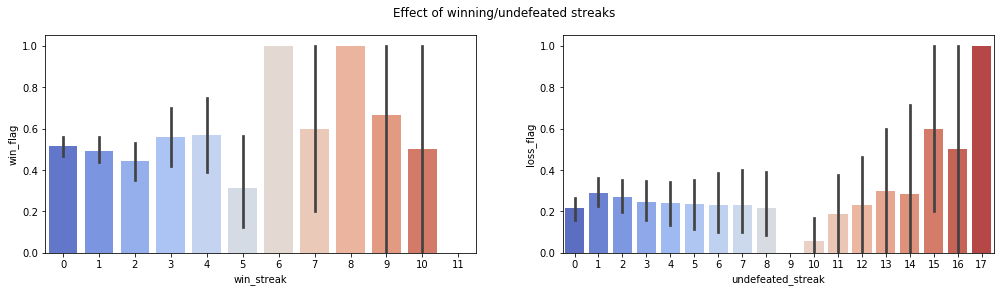

In [10]:
# Plot the streaks
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[17,4])
sns.barplot(data=df, x='win_streak', y='win_flag', ax=ax[0], palette='coolwarm')
sns.barplot(data=df, x='undefeated_streak', y='loss_flag', ax=ax[1], palette='coolwarm')
plt.suptitle('Effect of winning/undefeated streaks')
plt.show()

In [11]:
# Also drop the win_flag after its been used for visualsiation
df.drop(['win_flag', 'loss_flag'], axis=1, inplace=True)

### Create a stratified test set

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
df.reset_index(inplace=True, drop=True)
for train_index, test_index in split.split(df, df['result']):
    train = df.loc[train_index]
    test = df.loc[test_index]

In [13]:
sample_comparison = pd.DataFrame({
    'overall': df['result'].value_counts().sort_index() / len(df),
    'stratified': test['result'].value_counts().sort_index() / len(test),
    })
sample_comparison['strat. % error'] = 100 * (sample_comparison['stratified'] - sample_comparison['overall']) \
                                     / sample_comparison['overall']
sample_comparison

,overall,stratified,strat. % error
0,0.252772,0.254144,0.542793
1,0.505543,0.502762,-0.550063
2,0.241685,0.243094,0.582898


In [14]:
# Separate the labels
y_train = train.pop('result')
y_test = test.pop('result')

# Drop dates, but keep the training dates as a weight
train_weight = train.pop('date')
test.drop('date', axis=1, inplace=True)

### Build a model

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)

In [16]:
import lightgbm as lgbm

# Create a training set
categoricals = ['opposition', 'liverpool_at_home', 'day_of_week']
lgbm_train_set = lgbm.Dataset(data=train, label=y_train, 
                              categorical_feature=categoricals, 
                              weight=train_weight,
                              free_raw_data=False)

# Set the training parameters
lgbm_params = {'application': 'multiclass',
               'booting': 'gbdt',
               'metric': 'multi_logloss',
               'training_metric': True,
               'learning_rate': 0.05,
               'feature_fraction': 0.8,
               'min_data_in_leaf': 30,
               'num_leaves': 31,
               'num_classes': 3}

In [17]:
cv_results = lgbm.cv(train_set=lgbm_train_set, 
                     params=lgbm_params, 
                     nfold=5, 
                     verbose_eval=0, 
                     num_boost_round=100,
                     early_stopping_rounds=10)
best_iteration = len(cv_results['multi_logloss-mean'])
print(cv_results['multi_logloss-mean'][-1])

C:\Users\James\Anaconda3\lib\site-packages\lightgbm\basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.943636104287


In [18]:
clf = lgbm.train(train_set=lgbm_train_set, 
                 params=lgbm_params,
                 num_boost_round=best_iteration)

C:\Users\James\Anaconda3\lib\site-packages\lightgbm\basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [19]:
y_prob = clf.predict(test, num_iteration=best_iteration)
y_pred = y_prob.argmax(axis=1)

LGBM classification accuracy =  	 54.14%


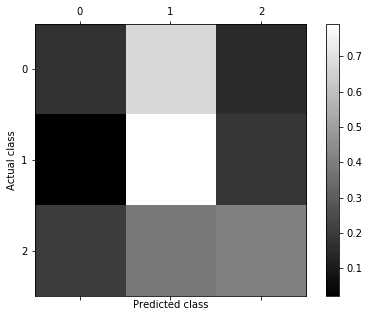

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

# Simple accuracy score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
print("LGBM classification accuracy =  \t {:.2f}%".format(100*accuracy))

# Visualise the confusion matrix, normalised for classification frequency
conf_matrix = confusion_matrix(y_test, y_pred)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums
# np.fill_diagonal(norm_conf_matrix, 0)

fig, ax = plt.subplots(figsize=[7,5])
conf_plot = ax.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.colorbar(ax=ax, mappable=conf_plot)
plt.show()

In [21]:
print(precision)
print(recall)

[ 0.42105263  0.6         0.42857143]
[ 0.17391304  0.79120879  0.40909091]


Lighter colors represent larger numbers in that position, so in this case we can see a lot of the errors are coming from draws (actual = 0) predicted to be wins (prediction = 1) in the centre-top position.

Second worst are losses predicted to be wins. This strongly indicates that winning predictions are the most wrong.

Sound like Liverpool?!

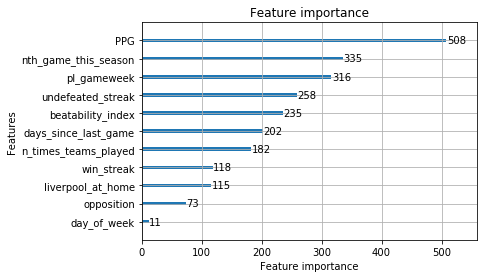

In [22]:
# Save model
clf.save_model(filename=os.path.join('models', 'lgbm_result_classifier.model'))

lgbm.plot_importance(clf)

### Predict a given game

In [23]:
train.head(1)

,nth_game_this_season,opposition,liverpool_at_home,beatability_index,day_of_week,days_since_last_game,win_streak,undefeated_streak,pl_gameweek,PPG,n_times_teams_played
732,13,17,False,0.4,5,10,1,1,10,1.5,47


In [34]:
# Upcoming game info
pred_game_date = '2018-01-14'
pred_game_opp = 'Manchester City'
liverpool_at_home = True
game_number_this_season = 29
days_since_last_game = 7
curr_win_streak = 3
curr_undefeated_streak = 7
pl_gameweek = 23
curr_PPG = 2

In [35]:
given_opp = processor.opposition_encoder.transform([pred_game_opp])
given_opp[0]

24

In [36]:
given_opp_times_played = processor.opposition_count_dict[given_opp[0]]
given_opp_times_played

37

In [37]:
pred_perf_metric = \
    processor.beatability_df.loc[ processor.beatability_df['opposition'] == pred_game_opp, 'beatability_index'].values
pred_perf_metric[0]

0.20000000000000001

In [38]:
pred_game = np.array([
    game_number_this_season,
    given_opp[0],
    liverpool_at_home,
    pred_perf_metric[0],
    pd.to_datetime(pred_game_date, format='%Y-%m-%d').weekday(),
    days_since_last_game,
    curr_win_streak,
    curr_undefeated_streak,
    given_opp_times_played,
    pl_gameweek,
    curr_PPG
], dtype='O').reshape([1, len(train.columns)])

In [39]:
y_prob_live = clf.predict(pred_game)
y_pred_live = y_prob_live.argmax(axis=1)

In [40]:
if liverpool_at_home:
    home_flag = 'H'
else:
    home_flag = 'A'
print('| {}: {} ({})| {:.2f} | {:.2f} | {:.2f} |  |  |  | '.format(pred_game_date, pred_game_opp, home_flag, 
                                                                   100*y_prob_live[0][1], 100*y_prob_live[0][0], 
                                                                   100*y_prob_live[0][2]))

| 2018-01-14: Manchester City (H)| 76.65 | 15.97 | 7.39 |  |  |  | 


In [41]:
print('Win probability: \t {:.2f}%'.format(100*y_prob_live[0][1]))
print('Loss probability: \t {:.2f}%'.format(100*y_prob_live[0][2]))
print('Draw probability: \t {:.2f}%'.format(100*y_prob_live[0][0]))

Win probability: 	 76.65%
Loss probability: 	 7.39%
Draw probability: 	 15.97%


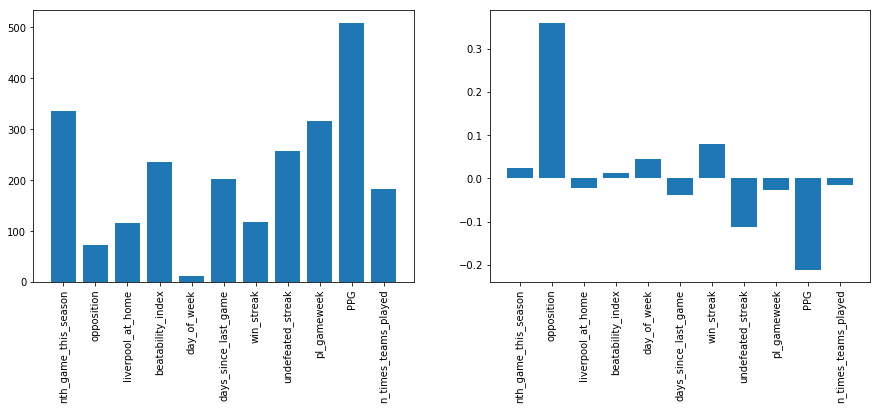

In [42]:
feature_contributions = clf.predict(pred_game, pred_contrib=True)
ind = np.arange(len(clf.feature_importance()))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,5])
ax[0].bar(ind, clf.feature_importance())
ax[1].bar(ind, feature_contributions.ravel()[:-1])
for axs in ax:
    axs.set_xticks(np.arange(len(clf.feature_importance())))
    axs.set_xticklabels(clf.feature_name(), rotation=90)
plt.show()

In [33]:
# Calculate log loss of prediction given actual result
from sklearn.metrics import log_loss

y_actual_live = np.array([[0, 1, 0]]) 
log_loss(y_actual_live, y_prob_live)

0.23962630570857182